In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import BertTokenizer, BertForSequenceClassification 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_df = pd.read_csv('pytorch/chap10/data/training.txt', sep='\t')
valid_df = pd.read_csv('pytorch/chap10/data/validing.txt', sep='\t')
test_df = pd.read_csv('pytorch/chap10/data/testing.txt', sep='\t')

In [3]:
train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [4]:
class Datasets(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1] 
        label = self.df.iloc[idx, 2]
        return text, label

In [6]:
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

100%|████████████████████████████████████████████████████████████████| 440473133/440473133 [01:30<00:00, 4885383.85B/s]
C:\Users\516-29\anaconda3\envs\ch08\lib\site-packages\pytorch_transformers\modeling_utils.py:539: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded f

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
def save_checkpoint(save_path, model, valid_loss): 
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(), 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model): 
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list): 
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [14]:
def train(model,
    optimizer,
    criterion=nn.BCELoss(),
    num_epochs=1,
    eval_every=len(train_loader)//2,
    best_valid_loss=float("Inf")):

    total_correct = 0.0
    total_len = 0.0
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    model.train()
    for epoch in range(num_epochs):
        for text, label in train_loader:
            optimizer.zero_grad()
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            outputs = model(sample, labels=labels)
            loss, logits = outputs
        
            pred = torch.argmax(F.softmax(logits), dim=1) 
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            global_step += 1
        
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    for text, label in valid_loader:
                        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
                        padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
                        sample = torch.tensor(padded_list)
                        sample, label = sample.to(device), label.to(device)
                        labels = torch.tensor(label)
                        outputs = model(sample, labels=labels)
                        loss, logits = outputs
                        valid_running_loss += loss.item()
        
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
        
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
        
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
        .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader), average_train_loss, average_valid_loss))
        
                if best_valid_loss > average_valid_loss: 
                    best_valid_loss = average_valid_loss
                    save_checkpoint('pytorch/chap10/data/model.pt', model, best_valid_loss) 
                    save_metrics('pytorch/chap10/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        
        save_metrics('pytorch/chap10/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\1771545418.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\1771545418.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\1771545418.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Epoch [1/1], Step [510/1020], Train Loss: 0.7092, Valid Loss: 0.6973
Model saved to ==> pytorch/chap10/data/model.pt
Model saved to ==> pytorch/chap10/data/metrics.pt
Epoch [1/1], Step [1020/1020], Train Loss: 0.7066, Valid Loss: 0.6936
Model saved to ==> pytorch/chap10/data/model.pt
Model saved to ==> pytorch/chap10/data/metrics.pt
Model saved to ==> pytorch/chap10/data/metrics.pt


Model loaded from <== pytorch/chap10/data/metrics.pt


C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\2668053387.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


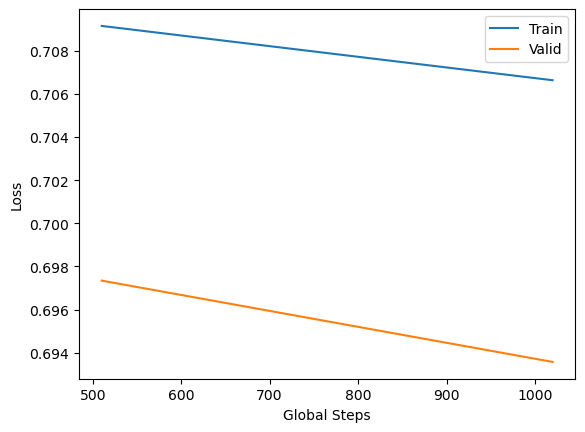

In [16]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('pytorch/chap10/data/metrics.pt') 

plt.plot(global_steps_list, train_loss_list, label='Train') 
plt.plot(global_steps_list, valid_loss_list, label='Valid') 
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval() 
    with torch.no_grad():
        for text, label in test_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            output = model(sample, labels=labels)
            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    print('Classification 결과:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0]) 
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\2668053387.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


Model loaded from <== pytorch/chap10/data/model.pt


C:\Users\516-29\AppData\Local\Temp\ipykernel_17168\3969822410.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Classification 결과:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       558
           0     0.4909    1.0000    0.6585       538

    accuracy                         0.4909      1096
   macro avg     0.2454    0.5000    0.3293      1096
weighted avg     0.2410    0.4909    0.3232      1096



C:\Users\516-29\anaconda3\envs\ch08\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\516-29\anaconda3\envs\ch08\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\516-29\anaconda3\envs\ch08\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


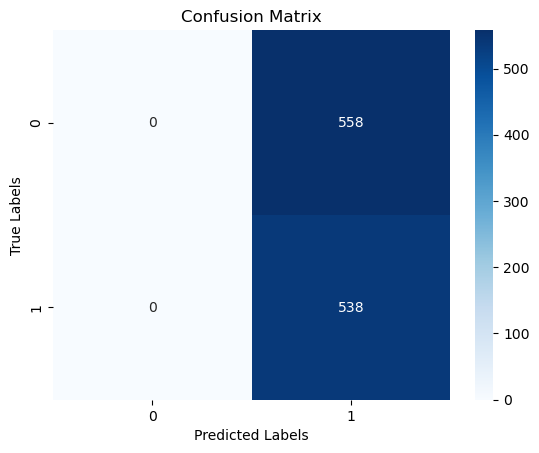

In [18]:
best_model = model.to(device)
load_checkpoint('pytorch/chap10/data/model.pt', best_model)
evaluate(best_model, test_loader)